<a href="https://colab.research.google.com/github/Brijeshtanwar/Topic-Modeling/blob/main/sklearn_nlp_fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# NLP libraries
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [105]:
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [106]:
url = """https://raw.githubusercontent.com/Brijeshtanwar/Topic-Modeling/main/voc_data.csv"""
df = pd.read_csv(url,  encoding = 'unicode_escape')

In [107]:
df = df[['CUSTOMER COMMENT', 'Reason']]
df.columns = ['comment', 'topic']

In [108]:
df.isnull().sum()

comment    0
topic      0
dtype: int64

In [109]:
# Drop na 
df.dropna(axis=0, inplace=True)

In [110]:
df.topic.value_counts()

Service                      1570
APPLICATION (WEB/APP)        1074
SERVICE                       335
CHARGES(BRO./DP/LPC ETC.)     332
Others                        321
NOT SPECIFIED                 254
Not Specified                 216
People                        113
Process                        69
PEOPLE                         32
Product                        13
PROCESS                         6
Name: topic, dtype: int64

In [111]:
#lower case
df['topic'] = df['topic'].str.lower()
df['topic'] = df['topic'].str.strip()
df.loc[df.topic=='not specified', 'topic'] = 'others'

In [112]:
df.topic.unique()

array(['service', 'application (web/app)', 'others',
       'charges(bro./dp/lpc etc.)', 'process', 'people', 'product'],
      dtype=object)

In [113]:
topic_dic = {'application (web/app)': 'application',  'charges(bro./dp/lpc etc.)': 'charges', 'service':'service'
, 'others':'others', 'process':'process', 'people':'people', 'product':'product'}

In [114]:
df['topic'] = df['topic'].map(topic_dic)

<Figure size 800x400 with 0 Axes>

<Axes: xlabel='count', ylabel='topic'>

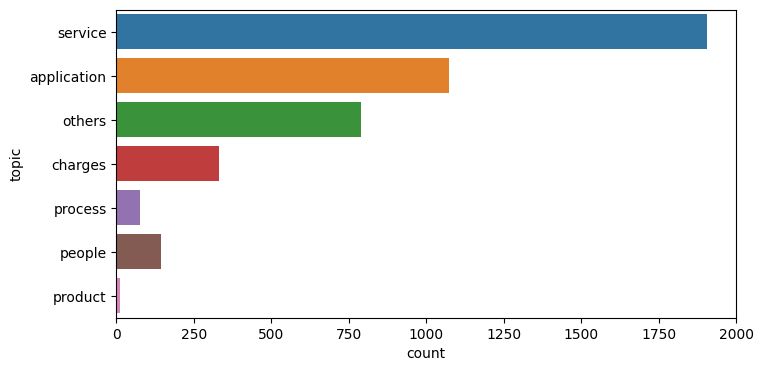

In [115]:
plt.figure(figsize=[8,4])
sns.countplot(y=df['topic'])

In [116]:
# Preprocessing

In [117]:
# Remove integer comments
df = df[df['comment'].apply(lambda x: not isinstance(x, int))]
df.reset_index(drop=True, inplace=True)

#lower case
df['comment'] = df['comment'].str.lower()

In [118]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and  characters and then strip)
    text = re.sub(r"[^A-Za-z]+", ' ' , str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [119]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords.remove('no')
lst_stopwords.remove('not')

In [120]:
# df["x"] = df["comment"].apply(lambda x: preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
df['x'] = df['comment']
df['y'] = df['topic']
df.head(10)

,comment,topic,x,y
0,querries where kotak is at disadvantageous pos...,service,querries where kotak is at disadvantageous pos...,service
1,1) same-day money deduction even if we have ma...,application,1) same-day money deduction even if we have ma...,application
2,ndejjejdjx,others,ndejjejdjx,others
3,worst website trading,application,worst website trading,application
4,"no technical support at real time, application...",service,"no technical support at real time, application...",service
5,need knowledge and experience person,service,need knowledge and experience person,service
6,please revisit my brokerage and deemat charges...,charges,please revisit my brokerage and deemat charges...,charges
7,iâm waiting for resolution or a meeting with...,service,iâm waiting for resolution or a meeting with...,service
8,i dint interacted so my rating may be a bias b...,service,i dint interacted so my rating may be a bias b...,service
9,no issues with the rm,service,no issues with the rm,service


In [121]:
df = df[['x', 'y']]

In [122]:
# Prefixing each row of the category column with '__label__'
df.iloc[:, 1] = df.iloc[:, 1].apply(lambda x: '__label__' + x)

In [123]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.33, stratify=df['y'], random_state=0)

In [124]:
import csv

In [125]:
pip install fasttext


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
import fasttext
# Saving the CSV file as a text file to train/test the classifier
df_train[['y', 'x']].to_csv('train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

df_test[['y', 'x']].to_csv('test.txt', 
                                     index = False, 
                                     sep = ' ',
                                     header = None, 
                                     quoting = csv.QUOTE_NONE, 
                                     quotechar = "", 
                                     escapechar = " ")


# Training the fastText classifier
model = fasttext.train_supervised('train.txt',lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50)

# Evaluating performance on the entire test file
model.test('test.txt')                      

# Predicting on a single input
# model.predict(ds.iloc[2, 0])

# Save the trained model
#model.save_model('model.bin')

(1431, 0.8085255066387141, 0.8085255066387141)

In [127]:
model.test('train.txt')

(2904, 0.9996556473829201, 0.9996556473829201)

In [128]:
df_test_pred = df_test
df_test_pred['y_pred'] = df_test_pred['x'].apply(model.predict)
df_test_pred['y_pred']=df_test_pred['y_pred'].str[0:1]
df_test_pred['y_pred'] = df_test_pred['y_pred'].astype(str)
df_test_pred['y_pred'] = df_test_pred['y_pred'].str[12:-5]
df_test_pred['y'] = df_test_pred['y'].str[9:]

ValueError: ignored

In [ ]:
df_pred = df
df_pred['y_pred'] = df_pred['x'].apply(model.predict)
df_pred['y_pred'] = df_pred['y_pred'].str[0:1]
df_pred['y_pred'] = df_pred['y_pred'].astype(str)
df_pred['y_pred'] = df_pred['y_pred'].str[12:-5]
df_pred['y'] = df_pred['y'].str[9:]

In [ ]:
df

In [ ]:
# Dict for classes
df_pred['category_id'] = df_pred['y'].factorize()[0]
category_id_df = df_pred[['y', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'y']].values)

In [ ]:
df_test_pred['category_id'] = df_test_pred['y'].map(category_to_id) 
df_test_pred['category_id_pred'] = df_test_pred['y_pred'].map(category_to_id) 
df_pred['category_id_pred'] = df_pred['y_pred'].map(category_to_id) 

In [ ]:
df_test_pred[df_test_pred['category_id_pred'].isnull()]

In [ ]:
df_test_pred.y_pred.unique()

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test_pred['category_id'], df_test_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report
from sklearn import metrics
print(metrics.classification_report(df_test_pred['category_id'], df_test_pred['category_id_pred'], target_names=df['y'].unique()))

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_pred['category_id'], df_pred['category_id_pred'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.y.values, yticklabels=category_id_df.y.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Classification report overall
from sklearn import metrics
print(metrics.classification_report(df_pred['category_id'], df_pred['category_id_pred'], target_names=df['y'].unique()))

In [ ]:
res = pd.DataFrame()
# To manually verify why some failed
from IPython.display import display

for predicted in category_id_df.category_id:
    for actual in category_id_df.category_id:
        if predicted != actual and conf_mat[actual, predicted] >= 10:
            # print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
            temp = df_pred.query(f' (category_id == {actual}) & (category_id_pred == {predicted})')[['x']]
            temp['y'] = id_to_category[actual]
            temp['y_pred'] = id_to_category[predicted]
            # print('')
            res = pd.concat([res,temp])

In [ ]:
from google.colab import data_table
data_table.DataTable(res, include_index=False, num_rows_per_page=10)